The real and imaginary part of dielectric permittivity of the metals is important to simulate the optical properties of metal films and nanoparticles. Permittivity data is obtained experimentally by ellipsometry and is fitted with analytical models. The most common model for fitting experimental data is with Drude-Lorentz model shown below. 

$$\epsilon(\omega)=1-\frac{f_1\omega_p^2}{(\omega^2+i\Gamma_1\omega)}+\sum_{j=2}^{n}\frac{f_j\omega_p^2}{(\omega_{o,j}^2-\omega^2-i\Gamma_j\omega)}$$

The first term is the Drude part. It represents the response of electron in the Fermi sea/conduction band when it sees external oscillating electric field (these transitions are called as intraband transitions). The Drude term has the plasma frequency ($\omega_p$, oscillator strengh ($f_1$) and damping term ($\Gamma_1$). The rest of the terms represent the Lorentz oscillators with specific resonance frequencies ($\omega_{o,j}$), oscillator strengths ($f_{j}$) and damping terms($\Gamma_j$) associated with them. They represent electron excitation from one band to another following an external oscillating electric field at certain resonance frequencies (these transitions are called as interband transitions).

Just out of curiosity, I wanted to do this fitting by myself for a long time now. So I attempted to fit the data with he commonly used fitting method, the least squares method, which involves minimization of the square of the error between the model and experimental data, while changing the parameters.  However I was not getting good fitting results even with several attempts, this may be due to the following problems with this method: 
- The fits were very sensitive to the initial guess values of the parameters (oscillator strengths, damping terms, etc). 
- The method is a local minimization technique. What that means is that the least square algorithm (Levenberg - Marquardt ) is changing the parameters in parameter space and searching for the minimum of sum of squares of difference between model and data. While doing this it can get trapped in a local minimum and report the parameters at that point as if it was as global minimum.
For more information on the problems of least-square method. See the last section of the article <a href ="http://www.itl.nist.gov/div898/handbook/pmd/section1/pmd141.htm">here</a>.

To avoid these problems, researchers use global optimization techniques. See, <a href ="https://www.osapublishing.org/ao/abstract.cfm?uri=ao-37-22-5271 "> Rakic et al.</a>  and  <a href =" http://iopscience.iop.org/article/10.1088/1464-4258/2/5/318/meta"> Djurisic et al.</a>. Rakic et al. used simulated annealing method , whic is a global optimization method and does a great job fitting experimental data. I wanted to use <a href="http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.anneal.html">Scipy's simulated annealing method</a> to fit the dielectric functions, but found that simulated annealing algorithm is deprecated in scipy 0.14 and they suggest using basin-hopping or differential evolution (DE) algorithms instead. 

I gave DE method a try because I didnot see any research article using DE algorithm for fitting dielectric data. If any of the readers find an article that uses DE to fit complex dielectric function, please point me to the article.  DE algorithm is a stochastic method that does not involve finding a gradient but rather involves mutation and recombination of random population of solutions. I dont completely understand the guts of the algorithm, but you can find more information <a href="https://en.wikipedia.org/wiki/Differential_evolution">here</a>. 

Below is my code of how I do the fitting of gold dielectric function with python and lmfit module. lmfit is a python module that provides a better and convinient fitting and optimization interface for Scipy optimize/minimze methods. The default minimization technique for lmfit is least square (Levenberg-marquardt) methood, so it needs to be changed to differential evolution. 

You can download my ipython notebook <a href="https://gist.github.com/plasmon360/ccf97d5d600ca4a3197ffa0e3d6cbe0b"> here</a> 

You can use this method for fitting other dielectric data, but have to tweak the bounds a little bit. If you use my implementation for your fitting your experimental data, please let me know or even better cite it as:

Juluri B.K. "Fitting Complex Metal Dielectric Functions with Differential Evolution Method". <a href="http://juluribk.com/?p=1597">http://juluribk.com/?p=1597</a>.





In the following code, I get the gold's experimental dielectric data from <a href="http://refractiveindex.info/">Refractiveindex.info</a>. 

In [12]:
import urllib2 # To make a request and gather data,

# Query the website

response = urllib2.urlopen('http://refractiveindex.info/database/main/Au/Babar.yml')

# Alternative Experimental data sources
# response = urllib2.urlopen('http://refractiveindex.info/database/main/Au/McPeak.yml')
# response = urllib2.urlopen('http://refractiveindex.info/database/main/Au/Lemarchand-3.96nm.yml')

# Read the response. Response is in YAML format. Will use PyYAML parser,
yaml_data = response.read()
import yaml
data =  yaml.load(yaml_data)

# Lets see what is inside the data,
print"Keys in the data:" , data.keys() 

# Lets print the reference for this data,
print "Reference : ", data['REFERENCES']

if 'COMMENTS' in data.keys():
    print "Comments : ", data['COMMENTS']

# Data seems to be stored in 'DATA', if needed uncomment the following line
#print(data['DATA'])

Keys in the data: ['REFERENCES', 'DATA']
Reference :  S. Babar and J. H. Weaver. Optical constants of Cu, Ag, and Au revisited, <a href="http://dx.doi.org/10.1364/AO.54.000477"><i>Appl. Opt.</i> <b>54</b>, 477-481 (2015)</a>


Data string contains real and imaginary part of the refractive index (not dielectric permitivitty). I clean up the real and imaginary part of the refractive data and convert them to dielectric permittivities

In [14]:
# Some clean up needed. The required data string holding wavelength, n and k, is in the form of dictionary item 
# with key 'data', which is inside a list\n",

cleaned_nk = data['DATA'][0]['data'] 

# Use StringIO to convert String buffer as a file like class\n",
import numpy as np
from StringIO import StringIO

# Read the data into as numpy vectors\n",
wave_micron, n, k  = np.genfromtxt(StringIO(cleaned_nk), unpack=True)

wave_exp = wave_micron * 1000 # Convert wavelength from microns to nm
eps_exp = (n + 1j* k)**2  # Convert n,k into dielectric function

# Lets convert wavelengh in nm to eV and assign it to 'w' 
h = 4.135667516E-15 # plancks's constant in eV-sec
c = 299792458E9 # speed of light in vacuum in nm/sec
w_exp = h*c/wave_exp;  # Convert wavleength in nm to eV

I define a function that will plot experimental dielectric data. It will also plot fitted models if the data is provided.

In [6]:

def plot_fit(w_exp,eps_exp, w_for_fit = None,eps_fit_result = None):
    '''
    This functions plots the experimental dielectric function as function of wavelength.
    If fitted model data is available it will also plot it
    '''

    %matplotlib inline
    import matplotlib.pyplot as plt
    from matplotlib.ticker import ScalarFormatter
    from matplotlib import rcParams
    
    rcParams.update({'font.size': 18}) # Increase the font size
    rcParams['mathtext.default']='regular' # make the mathtext the same size of normal text for better readbility
    
    # Plot the real part of the dielectric function
    fig,ax = plt.subplots(1,2,figsize = (12,5))
    ax[0].scatter(w_exp, abs(eps_exp.real), marker = 'o',facecolor = 'none', edgecolor = 'g')
    
    ax[0].set_xlabel('Energy (eV)')
    ax[0].set_ylabel(r'|$\epsilon^\prime$|')
        

    # Plot the imaginary part of the dielectric function
    ax[1].scatter(w_exp, eps_exp.imag, marker = 'o',facecolor = 'none', edgecolor = 'g')
    ax[1].set_ylabel(r'$\epsilon ^ {\prime \prime}$')
    ax[1].set_xlabel('Energy (eV)')
    
    # If the fit data is available we will plot it with the actual plots
    if (w_for_fit is not None and eps_fit_result is not None):
        ax[0].plot(w_for_fit, abs(eps_fit_result.real),'-r')
        ax[1].plot(w_for_fit,eps_fit_result.imag,'-r')
        
    
    # Set the grid, log and axis formatter
    for axis in ax:
        axis.grid('on')
        axis.set_xscale('log')
        axis.set_yscale('log')
        axis.set_xlim([min(w_exp),max(w_exp)])
        for x_yaxis in [axis.xaxis, axis.yaxis]:
            x_yaxis.set_major_formatter(ScalarFormatter())
            
    fig.tight_layout()
 


Lets plot the experimental data to see the data. Data seems to be from 0.1ev to 10eV. There seems to be three transitions (are all of them interband?) above 1eV

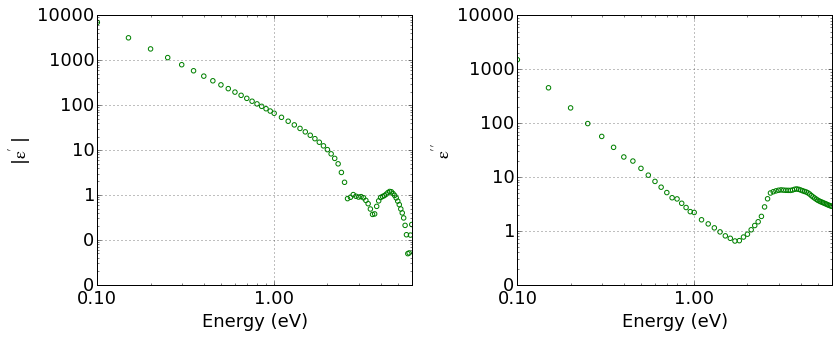

In [7]:
plot_fit(w_exp,eps_exp)

Lets define a Drude-Lorentz model. This will be the model we will try to fit the experimental data with. The model has one Drude term and five Lorentz oscillators

In [15]:
def drude_lorentz_model(params, w):
    '''
    This is functional representation of drude lorentz model with the first term being Drude
    and the rest terms being lorentz oscillators
    '''
    
    # Get the plasma frequency
    omega_p = params['Omega_p'].value
   
    
    # Get the Drude parms
    f0 = params['f0'].value
    gamma0 = params['Gamma0'].value

    # Get the first Lorentz term parameters,
    f1 = params['f1'].value
    gamma1 = params['Gamma1'].value
    omega1 = params['Omega1'].value
    
    # Get the second Lorentz term parameters
    f2 = params['f2'].value
    gamma2 = params['Gamma2'].value
    omega2 = params['Omega2'].value
    
    # Get the third Lorentz term parameters
    f3 = params['f3'].value
    gamma3 = params['Gamma3'].value
    omega3 = params['Omega3'].value

    # Get the fourth Lorentz term parameters
    f4 = params['f4'].value
    gamma4 = params['Gamma4'].value
    omega4 = params['Omega4'].value
    
    # Get the fifth Lorentz term parameters
    f5 = params['f5'].value
    gamma5 = params['Gamma5'].value
    omega5 = params['Omega5'].value

    # Drude component
    epsilon_D = 1 - (f0 * omega_p ** 2 / (w ** 2 + 1j * (gamma0) * w))

    # Lorentz first oscillator
    epsilon_L1 = (f1 * omega_p ** 2) / (omega1 ** 2 - w ** 2 - 1j * gamma1 * w)

    # Lorentz SEcond oscillator 
    epsilon_L2 = (f2 * omega_p ** 2) / (omega2 ** 2 - w ** 2 - 1j * gamma2 * w)

    # Lorentz Third oscillator 
    epsilon_L3 = (f3 * omega_p ** 2) / (omega3 ** 2 - w ** 2 - 1j * gamma3 * w)
    
    # Lorentz Fourth oscillator 
    epsilon_L4 = (f4 * omega_p ** 2) / (omega4 ** 2 - w ** 2 - 1j * gamma4 * w)
    
    # Lorentz Fifth oscillator 
    epsilon_L5 = (f5 * omega_p ** 2) / (omega5 ** 2 - w ** 2 - 1j * gamma5 * w)

    # Sum all the terms
    epsilon = epsilon_D + epsilon_L1 +epsilon_L2 +  epsilon_L3 +  epsilon_L4 +  epsilon_L5

    return epsilon

Lets define a callable function which returns a residual. This function will be used by our minimization algorithm. It is important to note how the residual is calculated as it is little bit different than normal fitting examples shown in lmfit, because we are minimizing complex data.

In [9]:
def complex_residuals(params, model, w, exp_data):
    '''
    This is the residual function that we will try to minimize.
    It takes the params dict that has the parameters that need to be found. 
   '''
    if model == 'Drude':
        # Our Drude model
        epsilon= drude_model(params,w)
    elif model == 'Drude-Lorentz':
        # Our Drude model
        epsilon= drude_lorentz_model(params,w)
        
    # Lets calculate our complex residual as the way it is done in page 5264
    # Rakic, a D.,et al (1998). Optical properties of metallic films for vertical-cavity optoelectronic devices. Applied Optics, 37(22), 5271–83.
    residual = (abs((epsilon.real - exp_data.real)/exp_data.real) + abs((epsilon.imag - exp_data.imag)/exp_data.imag))**2
    
    # if the residual is being used for least square optimizaiton we should have used
    # residual = (abs((epsilon.real - exp_data.real)/exp_data.real) + abs((epsilon.imag - exp_data.imag)/exp_data.imag))
    # least square method does the square of the residual in its algorithm. see http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.leastsq.html

    return residual

This is where differential evolution will be used to make a fit to the data. Differential evolution algorithm requires bounds for each parameter. I gave resonable bounds based on looking at the experimental data and hope to see what the algorithm does. It seem to do a resonable job and much better job than least squares method. **The fitting results will vary a little bit each time we run this cell. So run the cell couple of times to see if things change for better.**

differential_evolution step 1: f(x)= 182.623
differential_evolution step 2: f(x)= 182.623
differential_evolution step 3: f(x)= 182.623
differential_evolution step 4: f(x)= 50.6673
differential_evolution step 5: f(x)= 20.0853
differential_evolution step 6: f(x)= 20.0853
differential_evolution step 7: f(x)= 20.0853
differential_evolution step 8: f(x)= 20.0853
differential_evolution step 9: f(x)= 15.1101
differential_evolution step 10: f(x)= 15.1101
differential_evolution step 11: f(x)= 11.3224
differential_evolution step 12: f(x)= 8.07834
differential_evolution step 13: f(x)= 3.05303
differential_evolution step 14: f(x)= 3.05303
differential_evolution step 15: f(x)= 2.4401
differential_evolution step 16: f(x)= 2.4401
differential_evolution step 17: f(x)= 2.4401
differential_evolution step 18: f(x)= 2.4401
differential_evolution step 19: f(x)= 2.31825
differential_evolution step 20: f(x)= 2.26033
differential_evolution step 21: f(x)= 2.09022
differential_evolution step 22: f(x)= 2.00165
d

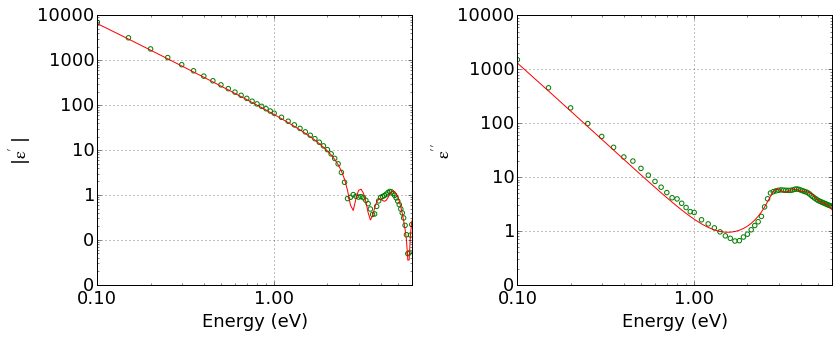

In [17]:
# Note that lmfit should be Version > 0.9.0. We will check this
import lmfit
from distutils.version import StrictVersion
assert StrictVersion(lmfit.__version__) > StrictVersion("0.9.0")

from lmfit import minimize, Parameters, printfuncs

# Choose the model we want to fit it with 
model = 'Drude-Lorentz'

params = Parameters()
params.add('Omega_p', value = 9, min = 8.5 , max = 10) # Omega_p has a value in eV, we will add a starting guess here

# Drude Term
params.add('f0', value=0.5, min = 1E-10, max = 1) # f  has no units,  we will add a starting guess here 
params.add('Gamma0', value= 0.03 , min = 1E-10, max = 0.1 ) # Gamma is damping term and has units in eV, we will add a starting guess here

# Lorentz first Oscillator term
params.add('f1', value=0.5, min = 1E-10, max = 1) # f  has no units,  we will add a starting guess here 
params.add('Gamma1', value= 0.5, min = 1E-10 ,  max = 2) # Gamma is damping term and has units in eV, we will add a starting guess here
params.add('Omega1', value = 5 , min = 5 , max = 10) # Omega_o is oscillator central frequency term  and has units in eV. we will add a starting guess here

# Lorentz Second Oscillator term
params.add('f2', value=0.5, min = 1E-10, max = 1) # f  has no units,  we will add a starting guess here 
params.add('Gamma2', value= 0.5, min = 0.01,  max = 2 ) # Gamma is damping term and has units in eV, we will add a starting guess here
params.add('Omega2', value = 3 , min = 2.5 , max = 3.5) # Omega_o is oscillator central frequency term  and has units in eV. we will add a starting guess here

# Lorentz Third Oscillator term
params.add('f3', value=0.5, min = 1E-10, max = 1) # f  has no units,  we will add a starting guess here 
params.add('Gamma3', value= 1, min = 0.01 , max = 2) # Gamma is damping term and has units in eV, we will add a starting guess here
params.add('Omega3', value = 4 , min = 3.5, max = 4.5 ) # Omega_o is oscillator central frequency term  and has units in eV. we will add a starting guess here

# Lorentz Fourth Oscillator term
params.add('f4', value=0.5, min = 1E-10, max = 1) # f  has no units,  we will add a starting guess here 
params.add('Gamma4', value= 1, min = 0.01 , max = 2) # Gamma is damping term and has units in eV, we will add a starting guess here
params.add('Omega4', value = 5 , min = 4.5, max = 5.5 ) # Omega_o is oscillator central frequency term  and has units in eV. we will add a starting guess here

# Lorentz Fifth Oscillator term
params.add('f5', value=0.5, min = 1E-10, max = 1) # f  has no units,  we will add a starting guess here 
params.add('Gamma5', value= 1, min = 0.01 , max = 2) # Gamma is damping term and has units in eV, we will add a starting guess here
params.add('Omega5', value = 6 , min = 5.5, max = 6.5 ) # Omega_o is oscillator central frequency term  and has units in eV. we will add a starting guess here



# Lets fit to all the data.
w_for_fit = w_exp
eps_for_fit = eps_exp

# if we were to fit only a part of the data such as fit only below 2 ev
#w_for_fit = w_exp[w_exp<2]
#eps_for_fit = eps_exp[w_exp<2]


# Call the minimize function with required parameters and use differential evolution as a method 
minimizer_results = minimize(complex_residuals, params, args=(model, w_for_fit, eps_for_fit), method = 'differential_evolution', strategy='best1bin',
                             popsize=50, tol=0.01, mutation=(0, 1), recombination=0.9, seed=None, callback=None, disp=True, polish=True, init='latinhypercube')

# If we were to fit ith with least squares methods
# minimizer_results = minimize(complex_residuals, params, args=(model, w_for_fit, eps_for_fit), method = 'leastsq')
                             
#lets see whether the fit exited successfully?
print "Print exited successfully? :  ", minimizer_results.success

#lets see the termination status
print "Termination Status: ", minimizer_results.message

# lets print the fit report. We dont need lengthy Correlation table
printfuncs.report_fit(minimizer_results, show_correl=False)

# Caluclate the epsilon based on the fit results
eps_fit_result = np.array([drude_lorentz_model(minimizer_results.params, i) for i in w_for_fit])

# Lets plot the fit data
plot_fit(w_exp,eps_exp, w_for_fit,eps_fit_result)
